References <br>
https://medium.com/analytics-vidhya/building-a-text-classification-model-using-bilstm-c0548ace26f2 <br>
https://github.com/pashupati98/text-classification

Glove word embeddings from https://www.kaggle.com/datasets/watts2/glove6b50dtxt



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
import re
from io import StringIO
import pandas as pd

data_path = '/content/Suicide_Detection.csv'
df = pd.read_csv(data_path, engine='python', encoding= 'unicode_escape', error_bad_lines=False, usecols=range(3), nrows=10000)
df = df.drop(df.columns[0], axis=1) # Drop the first index column

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
print(df.shape)
df.head()

(10000, 2)


,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"Iâm so lostHello, my name is Adam (16) and I...",suicide


### Preprocessing

In [ ]:
!pip install contractions

     |████████████████████████████████| 287 kB 36.0 MB/s 
     |████████████████████████████████| 106 kB 76.0 MB/s 


In [ ]:
#importing required libraries
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

# First function is used to denoise text
def denoise_text(text):
    # Strip html if any. For ex. removing <html>, <p> tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    # Replace contractions in the text. For ex. didn't -> did not
    text = contractions.fix(text)
    return text
# Check the function 
sample_text = "<p>he didn't say anything </br> about what's gonna <html> happen in the climax"
denoise_text(sample_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'he did not say anything  about what is going to  happen in the climax'

In [ ]:
# Text normalization includes many steps.
# Each function below serves a step.
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
          try:
            new_word = p.number_to_words(word)
            new_words.append(new_word)
          except:
            print(word)
        else:
            new_words.append(word)
    return new_words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas
def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    #words = stem_words(words)
    words = lemmatize_verbs(words)
    return words
# Testing the functions
print("remove_non_ascii results: ", remove_non_ascii(['h', 'ॐ', '©', '1']))
print("to_lowercase results: ", to_lowercase(['HELLO', 'hiDDen', 'wanT', 'GOING']))
print("remove_punctuation results: ", remove_punctuation(['hello!!', 'how?', 'done,']))
print("replace_numbers results: ", replace_numbers(['1', '2', '3']))
print("remove_stopwords results: ", remove_stopwords(['this', 'and', 'amazing']))
print("stem_words results: ", stem_words(['beautiful', 'flying', 'waited']))
print("lemmatize_verbs results: ", lemmatize_verbs(['hidden', 'walking', 'ran']))
print("normalize_text results: ", normalize_text(['hidden', 'in', 'the', 'CAVES', 'he', 'WAited', '2', 'ॐ', 'hours!!']))

remove_non_ascii results:  ['h', '', '', '1']
to_lowercase results:  ['hello', 'hidden', 'want', 'going']
remove_punctuation results:  ['hello', 'how', 'done']
replace_numbers results:  ['one', 'two', 'three']
remove_stopwords results:  ['amazing']
stem_words results:  ['beauty', 'fly', 'wait']
lemmatize_verbs results:  ['hide', 'walk', 'run']
normalize_text results:  ['hide', 'cave', 'wait', 'two', 'hours']


In [ ]:
# Tokenize tweet into words
def tokenize(text):
    return nltk.word_tokenize(text)
# check the function
sample_text = 'he did not say anything  about what is going to  happen'
print("tokenize results :", tokenize(sample_text))

tokenize results : ['he', 'did', 'not', 'say', 'anything', 'about', 'what', 'is', 'going', 'to', 'happen']


In [ ]:
def text_prepare(text):
    try:
      text = denoise_text(text)
      text = ' '.join([x for x in normalize_text(tokenize(text))])
      return text
    except:
      print("text_prepare", text)
      return ""
df['text'] = [text_prepare(x) for x in df['text']]
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])
df.head()

2929292822882828881818181899999888282
3333333333333333333333333333333333333333333333


,text,class
0,ex wife threaten suiciderecently leave wife go...,1
1,weird get affect compliment come someone know ...,0
2,finally two thousand and twenty almost never h...,0
3,need helpjust help cry hard,1
4,iam losthello name adam sixteen iave struggle ...,1


In [ ]:
print(df.shape)

(10000, 2)


In [ ]:
df.to_csv('Suicide_Detection_Cleaned_10000.csv')

In [ ]:
df.loc[df['class'] == 1, 'class'].count()
df.loc[df['class'] == 0, 'class'].count()

5085

### Model Training

In [ ]:
from keras.layers import Dropout, Dense, GRU, Embedding, LSTM, Bidirectional, TimeDistributed, Flatten
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open("/content/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)

In [ ]:
def Build_Model_RNN_Text(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    """
    def buildModel_RNN(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    word_index in word index ,
    embeddings_index is embeddings index, look at data_helper.py
    nClasses is number of classes,
    MAX_SEQUENCE_LENGTH is maximum lenght of text sequences
    """
    model = Sequential()
    hidden_layer = 3
    lstm_node = 32
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    print(lstm_node)
    for i in range(0,hidden_layer):
        model.add(Bidirectional(LSTM(lstm_node,return_sequences=True, recurrent_dropout=0.2)))
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))
    model.add(Dropout(dropout))
    #model.add(TimeDistributed(Dense(256)))
    #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [ ]:
def experiment(df):
  print("Running Experiment ... ")
  X = df['text']
  y = df['class']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
  print("Generating Glove ...")
  X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)
  with warnings.catch_warnings():
    print("Building Model ...")
    model_RNN = Build_Model_RNN_Text(word_index,embeddings_index, 2)
    model_RNN.summary()
    print("\n Starting Training ... \n")
    history = model_RNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=10,
                              batch_size=128,
                              verbose=1)
    warnings.simplefilter("ignore")
  print("\n Plotting results ... \n")
  plot_graphs(history, 'accuracy')
  plot_graphs(history, 'loss')
  print("\n Evaluating Model ... \n")
  predicted = model_RNN.predict(X_test_Glove)
  predicted = np.argmax(predicted, axis=1)
  #print(predicted)
  print(metrics.classification_report(y_test, predicted))
  print("\n")
  logger = logging.getLogger("logger")
  result = compute_metrics(y_test, predicted)
  for key in (result.keys()):
      logger.info("  %s = %s", key, str(result[key]))
  return model_RNN

In [ ]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def class_balance(df, target):
  cls = df[target].value_counts()
  cls.plot(kind='bar')
  plt.show()

In [ ]:
solid = shuffle(df)

Running Experiment ... 
Generating Glove ...
Found 26709 unique tokens.
(10000, 500)
Total 400000 word vectors.
Building Model ...
32


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 50)           1335500   
                                                                 
 bidirectional_8 (Bidirectio  (None, 500, 64)          21248     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 500, 64)         

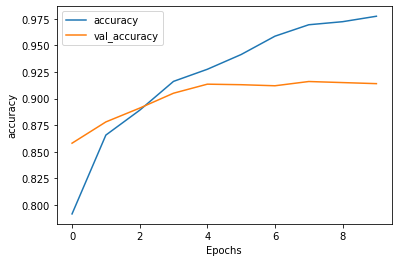

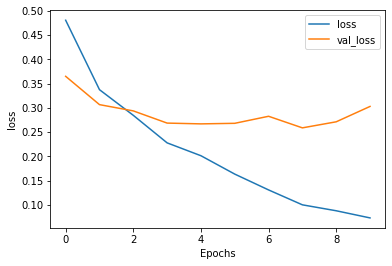


 Evaluating Model ... 



INFO:logger:  mcc = 0.8282425131362273
INFO:logger:  tp = 903
INFO:logger:  tn = 925
INFO:logger:  fp = 98
INFO:logger:  fn = 74
INFO:logger:  pricision = 0.9020979020979021
INFO:logger:  recall = 0.9242579324462641
INFO:logger:  F1 = 0.9130434782608695
INFO:logger:  accuracy = 0.914


              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1023
           1       0.90      0.92      0.91       977

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000





In [ ]:
model = experiment(solid)

In [ ]:
model.save('/content/model')

INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


In [ ]:
!zip -r /content/model.zip /content/content/model
from google.colab import files
files.download("model.zip")

updating: content/content/model/ (stored 0%)
updating: content/content/model/keras_metadata.pb (deflated 94%)
updating: content/content/model/saved_model.pb (deflated 91%)
updating: content/content/model/variables/ (stored 0%)
updating: content/content/model/variables/variables.data-00000-of-00001 (deflated 14%)
updating: content/content/model/variables/variables.index (deflated 74%)
updating: content/content/model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Do Prediction on Local Test Data

In [ ]:
local_data_path = '/content/local_data_clean.csv'
ldf = pd.read_csv(local_data_path)
print(ldf.shape)
ldf.head()

(46, 3)


,Unnamed: 0,text,class
0,0,pain never go become anything never go live wa...,1
1,1,suicidal thoughts every single day years gener...,1
2,2,much pain everything hurt much go take life ma...,1
3,3,plan spend time family much possible next mont...,1
4,4,get make look like accident want family miss i...,1


In [ ]:
def convert_to_embeddings(X, MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    text = np.array(X)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    embeddings_index = {}
    f = open("/content/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (text, word_index,embeddings_index)

In [ ]:
text, word_index, embeddings_index = convert_to_embeddings(ldf['text'])

Found 1108 unique tokens.
(46, 500)
Total 400000 word vectors.


In [ ]:
import time
single_text = text[:1]
single_text.shape

tries = []
for i in range(300):
  start = time.time()
  single_predicted = model.predict(single_text)
  end = time.time()
  tries.append(end-start)
print("Average time taken: ", sum(tries) / len(tries))

Average time taken:  1.2169384956359863


In [ ]:
predicted = model.predict(text)
predicted = np.argmax(predicted, axis=1)

y_test = ldf['class']

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))

INFO:logger:  mcc = 0.3152641443777315
INFO:logger:  tp = 18
INFO:logger:  tn = 12
INFO:logger:  fp = 11
INFO:logger:  fn = 5
INFO:logger:  pricision = 0.6206896551724138
INFO:logger:  recall = 0.782608695652174
INFO:logger:  F1 = 0.6923076923076923
INFO:logger:  accuracy = 0.6521739130434783


              precision    recall  f1-score   support

           0       0.71      0.52      0.60        23
           1       0.62      0.78      0.69        23

    accuracy                           0.65        46
   macro avg       0.66      0.65      0.65        46
weighted avg       0.66      0.65      0.65        46



